In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import f_classif

%matplotlib inline

In [2]:
DATASET_PATH = 'audio_features/Parkinsons disease.csv'
RANDOM_SEED = 0
PCA_NB_COMP = 2
ANOVA_F_TOP_K = None
PLOT_FLAG = True
NB_LABELS = 2

In [3]:
df = pd.read_csv(DATASET_PATH)

In [4]:
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [5]:
df.status.value_counts(normalize=True)*100

1    75.384615
0    24.615385
Name: status, dtype: float64

# 1: PD
# 0: Healthy

In [6]:
df.columns

Index(['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')

In [7]:
COLS_SET = set(df.columns)
UNUSED_FEATURE_COLS = ['name', 'status']

for COL in UNUSED_FEATURE_COLS:
    COLS_SET.remove(COL)
FEATURE_COLS = list(COLS_SET) # ['PPE', 'HNR', 'RPDE', 'DFA']# 

OUTPUT_COLS = ['status']

X, y = df[FEATURE_COLS].to_numpy(), df[OUTPUT_COLS].to_numpy()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_SEED)
del X, y

In [9]:
class_weight = {i: (y_train.shape[0] / nb_samples) for i, nb_samples in zip(*np.unique(y_train, return_counts=True))}

# Comment out below two lines if class-weighing is desired
# class_weight[0] = 1
# class_weight[1] = 1

print(class_weight)

{0: 4.105263157894737, 1: 1.3220338983050848}


In [10]:
if PCA_NB_COMP is not None:
    pca = PCA(n_components=PCA_NB_COMP, random_state=RANDOM_SEED)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
    
if ANOVA_F_TOP_K is not None:
    f_stats, _ = f_classif(X_train, y_train)
    
    mask = np.argpartition(f_stats, -ANOVA_F_TOP_K)[-ANOVA_F_TOP_K:]
    X_train = X_train[:, mask]
    X_test = X_test[:, mask]
    print(np.array(FEATURE_COLS)[mask])

In [11]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
def calc_metrics(model, X, y):
    y_pred = model.predict(X)
    
    metrics = {}
    
    metrics['acc'] = model.score(X, y)
    
    # conf_mat = confusion_matrix(y, y_pred)
    # metrics['tn'] = conf_mat[0][0]
    # metrics['fp'] = conf_mat[0][1]
    # metrics['fn'] = conf_mat[1][0]
    # metrics['tp'] = conf_mat[1][1]
    
    metrics['prec'], metrics['recall'], metrics['f1'], _ = precision_recall_fscore_support(y, y_pred, average='binary')
    
    # metrics['auc'] = roc_auc_score(y, model.predict_proba(X)[:, 1])
    
    return metrics

In [13]:
models = {
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_SEED, class_weight=class_weight),
    'Random Forest': RandomForestClassifier(n_estimators=20,
                                            random_state=RANDOM_SEED,
                                            class_weight=class_weight),
    'K-Nearest Neighbor': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression': LogisticRegression(solver='liblinear',
                                              multi_class='ovr',
                                              random_state=RANDOM_SEED,
                                              max_iter=5000),
    'Support Vector Classifier': SVC(class_weight=class_weight,
                                                  random_state=RANDOM_SEED, probability=True),
    'MultiLayer Perceptron': MLPClassifier(solver='adam',
                                           activation='relu',
                                           hidden_layer_sizes=(5, 10),
                                           random_state=RANDOM_SEED, 
                                           max_iter=5000)
}

In [14]:
def get_2d_grid(x_range, y_range, x_step: float, y_step: float):
    x_grid = np.arange(x_range[0], x_range[1], x_step)
    y_grid = np.arange(y_range[0], y_range[1], y_step)
    
    xx, yy = np.meshgrid(x_grid, y_grid)
    return xx, yy, np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

min_pc1, max_pc1 = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
min_pc2, max_pc2 = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy, grid = get_2d_grid([min_pc1, max_pc1], [min_pc2, max_pc2], .1, .1)

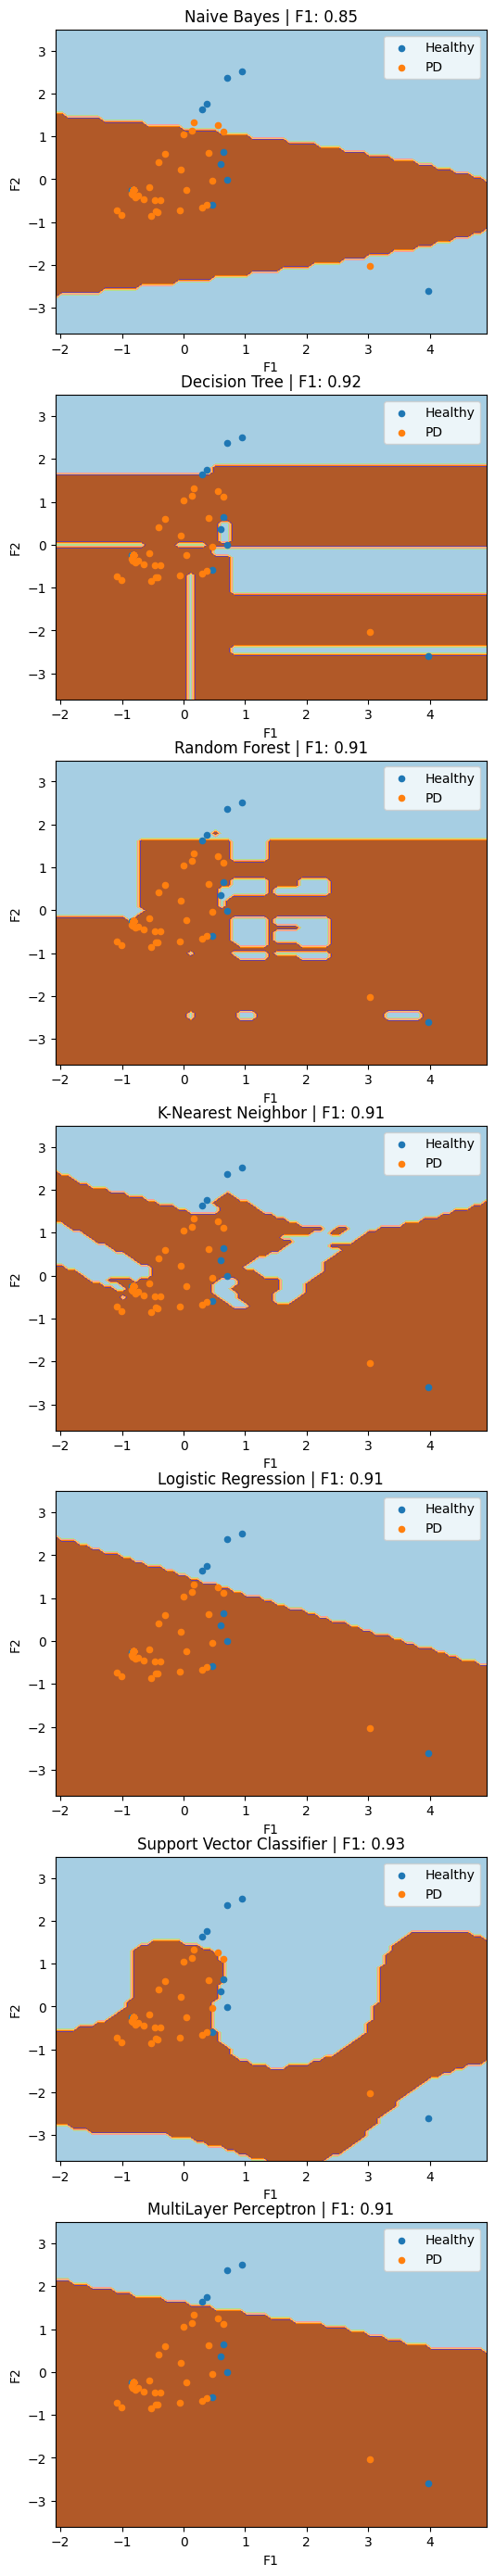

In [15]:
results = {
    'Name': [], 
    'Accuracy': [], 
    # 'TN': [], 
    # 'FP': [], 
    # 'FN': [], 
    # 'TP': [], 
    'Precision': [], 
    'Recall': [], 
    'F1 Score': [], 
    # 'ROC-AUC Score': []
}

label_names = ['Healthy', 'PD']

if PLOT_FLAG:
    fig, axes = plt.subplots(len(models), 1)
    fig.set_figheight(5 * len(models))
    fig.set_figwidth(6)

data = [[X_test, y_test]]

for i, (model_name, model) in enumerate(models.items()):
    # print('\n---->', model_name, '\n')
    model.fit(X_train, y_train.ravel())

    test_metrics = calc_metrics(model, X_test, y_test)
    
    # print('Test > ', test_metrics)
    
    results['Name'].append(model_name)
    results['Accuracy'].append(test_metrics['acc'])
    # results['TN'].append(test_metrics['tn'])
    # results['FP'].append(test_metrics['fp'])
    # results['FN'].append(test_metrics['fn'])
    # results['TP'].append(test_metrics['tp'])
    results['Precision'].append(test_metrics['prec'])
    results['Recall'].append(test_metrics['recall'])
    results['F1 Score'].append(test_metrics['f1'])
    # results['ROC-AUC Score'].append(test_metrics['auc'])
    
    if PLOT_FLAG:
        grid_preds = model.predict(grid)
        zz = grid_preds.reshape(xx.shape)

        for j, (X, y) in enumerate(data): 
            axes[i].contourf(xx, yy, zz, cmap='Paired')
            axes[i].set_xlabel('F1')
            axes[i].set_ylabel('F2')
            axes[i].set_title(f'{model_name} | F1: {test_metrics["f1"]:.2f}')
            for label in range(NB_LABELS):
                indices = np.where(y == label)
                axes[i].scatter(X[indices, 0], X[indices, 1], cmap='Paired', label=label_names[label], s=20)
                axes[i].legend()

In [16]:
# results_df = pd.DataFrame(results)
# results_df.to_csv('results_pc2.csv', float_format="%.4f", index=False)